In [20]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from balancers import PredictionBalancer
import tools

## Working with a binary predictor
### Checking for bias
First, let's load our data. Here we're using a synthetic dataset about pets that need some TLC. 

In [21]:
pets = pd.read_csv('data/farm_animals.csv')
pets.head()

,animal,action,pred_action,shear,shear_pred,shear_prob
0,dog,feed,feed,0,0,0.8917
1,dog,feed,pet,0,0,0.6248
2,cat,shear,shear,1,1,0.4187
3,dog,feed,feed,0,0,0.1347
4,sheep,feed,pet,0,0,0.2754


In the data, we have information about the kind of pet (`animal`), what it kind of care it needs (`action`), and what kind of care we think it needs (`pred_action`).

For the following examples, we'll use `animal` as our protected category. 

In [22]:
a = pets.animal.values

Next, we'll set the true outcome variable, `Y`. `action` is what each animal would like us to do, but it's a multiclass variable, so we'll pick one level and make sure we're fair with respect to that. Since shaving an animal has the potential to be traumatizing, let's go with `shear`.

In [23]:
y = np.array(pets.action == 'shear', dtype=np.uint8)

Our potentially biased predictor in this case will be `pred_action`. Let's call it `y_`.

In [24]:
y_ = np.array(pets.pred_action == 'shear', dtype=np.uint8)

Before stratifying by `animal`, let's start by seeing how good our predictions are overall. For that we'll use `tools.clf_metrics()`, which will generate lots of helpful statistics.

In [25]:
shear_stats = tools.clf_metrics(y, y_)

In [26]:
shear_stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,111.0,166.0,673.0,50.0,0.6894,0.8021,0.4007,0.9308,0.4915,0.5068,0.403724,0.216,0,0,161.0,277.0,116.0,0.7205


Overall, true positive rate (`sens`) is .69, and our false positive rate (1 - `spec`) is .20--not bad! Now let's see whether these results are balanced with respect to `animal`.

In [27]:
pb = PredictionBalancer(y=y, y_=y_, a=a)


Pre-adjustment group rates are 

group     fpr     tpr
  cat  0.1652  0.4419
  dog   0.258   0.641
sheep  0.1048  0.8481

And loss is 0.2160



Ah! We can see that the rates are pretty different across groups. In sheep, `tpr` and `fpr` are great--makes sense, since it's pretty easy to tell when to shave a sheep--but they're substantially worse for cats and dogs. 

### Adjusting biased predictions
Let's use the `.adjust()` method to see if we can achieve the same `fpr` and `tpr` (AKA equalized odds) across groups.

In [28]:
pb.adjust(goal='odds', summary=False)

{'loss': 0.2722941030748741, 'roc': (0.1825, 0.4535)}

`.adjust()` returns the theoretical optima for loss (1 - accuracy, in this case) and the ROC coordinates after adjustment. With equalized odds, the best we can do for all groups is a FPR of 18% and TPR of 45%, and loss goes up by about 6%.

The adjuster can also print the ROC coordinates for the model's empirical predictions on the original dataset (normally it does this by default, but we've supressed it here to keep the presentation clean). 

In [29]:
pb.summary(org=False)


Post-adjustment group rates are 

group     fpr     tpr
  cat  0.1799  0.4651
  dog  0.1862  0.4103
sheep  0.1694  0.4557

And loss is 0.2410



Notice that the predicted rates are a bit different from the theoretical optima returned by `.adjust()`. The variability here comes from the `fpr` and `tpr` of the original predictor--the adjusted predictions come from randomly picking which of those original predictions to set to `1`, but since not all of those are perfect, we get a different blend of correct guesses each time, hence the movement in the realized rates. Despite this variability, the long-run averages for the rates will be the same, though, which is the best we can do with an oblivious predictor.

### Visualizing the predictions and the adjustments
The balancer's `.plot()` function shows all of this data in action.

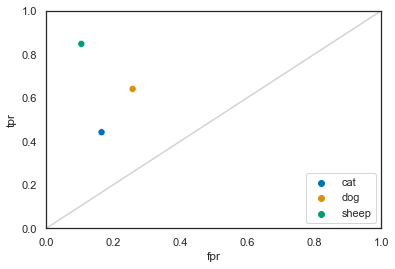

In [30]:
pb.plot(optimum=False, lp_lines=False)

Here we see the original three points in ROC space. The difference in `tpr` between all 3 groups is apparent, but especially so between cats and sheep.

If `.adjust()` has been called, `.plot()` will plot the optimum point (or line, in the case of equal opportunity) by default. In this case, the coordiante for the worst-performing group is achievable by adjusting for the others, and so that becomes the optimum for everyone.

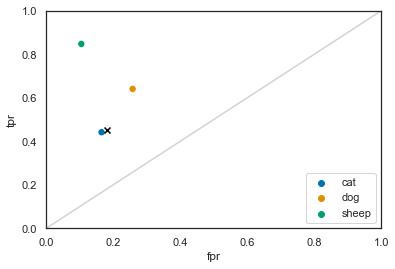

In [31]:
pb.plot(lp_lines=False)

To see how random sampling affects the error rates, we can plot the observed ROC coordinates for the adjusted predictions. Again, these are a bit different from the theoretical optimum, but over the long-run they'll average out correctly.

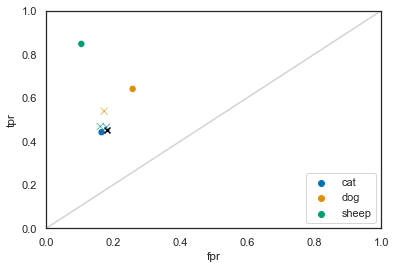

In [13]:
pb.plot(preds=True, lp_lines=False)

Finally, we can plot the convex hulls showing *all* of the achievable ROC points for each group. The intersection of the hulls are rates we can achieve for all groups at once, and the point in the intersection with the lowest loss (generally closest to the top left corner of the plot) is what the linear program in `.adjust()` picks as the optimum.

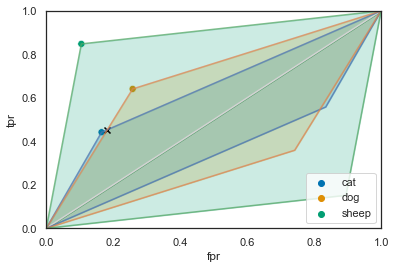

In [14]:
pb.plot()

The optimum is a bit hard to see, but zooming in shows the intersection nicely.

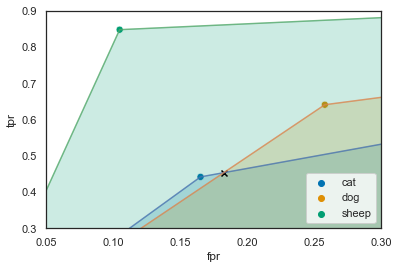

In [15]:
pb.plot(xlim=(0.05, .3), ylim=(.3, .9))

## Working with a real-valued predictor

The `PredictionBalancer` can also handle real-valued predictors (non-probabilistic scores are normalized to be betwee 0 and 1). Here, we'll use whether the animal needs to be shorn as our target, and we'll use the predicted shear probabilities (`shear_prob`) as our predictor.

In [16]:
pb_roc = PredictionBalancer(y=pets.shear, y_=pets.shear_prob, a=pets.animal)

Probabilities detected.


Pre-adjustment group rates are 

group     fpr     tpr
  cat  0.2537  0.7907
  dog  0.4202  0.8974
sheep  0.0565  0.8987

And loss is 0.2720



`tpr` looks relatively stable across groups, but there are some big differences in `fpr`, especially between dogs and sheep. Let apply the adjustment for equalized odds to see if we can do better.

In [17]:
pb_roc.adjust(goal='odds')


Post-adjustment group rates are 

group     fpr     tpr
  cat  0.3923  0.7907
  dog  0.3883  0.8205
sheep   0.379  0.8228

And loss is 0.3560



{'loss': 0.3249006252562848, 'roc': (0.3879, 0.8283)}

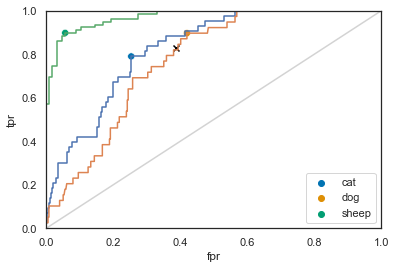

In [18]:
pb_roc.plot(lp_lines=False)

Using `.plot()` with `lp_lines` set to `True` will show the convex hulls corresponding to the thresholded predictions. Here, we'll drop the ROC curves to show the geometry of the solution more clearly.

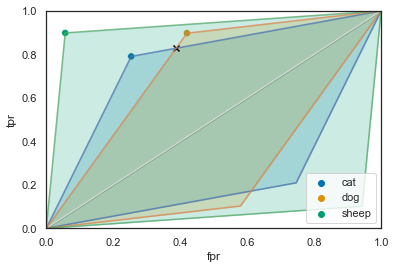

In [19]:
pb_roc.plot(roc_curves=False)